In [2]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
with open("datasets/parsed_filtered_df.pkl", "rb") as handle:
    main_df = pickle.load(handle)

In [4]:
main_df_opinion = main_df[main_df["sentiment"] != 0]

In [5]:
def search_df(df, search_terms, search_exclusive=False):
    # Lowercase search terms
    search_terms = [t.lower() for t in search_terms]
    
    # Create a boolean array to subset the dataframe with search matching terms
    if search_exclusive:
        search_filter_bool = np.ones(len(df), dtype=bool)
        
        for term in search_terms:
            search_filter_bool = search_filter_bool & df['main'].str.lower().str.contains(term)
    else:
        search_filter_bool = np.zeros(len(df), dtype=bool)

        for term in search_terms:
            search_filter_bool = search_filter_bool | df['main'].str.lower().str.contains(term)
    
    return df[search_filter_bool]

In [6]:
def append_state_code(df):
    '''Adds state code in a new column, in place'''
    
    state_to_code = {
        'Zurich': 'ZH', 
        'Solothurn': 'SO', 
        'Geneva': 'GE', 
        'Lucerne': 'LU', 
        'Thurgau': 'TG', 
        'Jura': 'JU',
        'Grisons': 'GR', 
        'Valais': 'VS', 
        'Fribourg': 'FR', 
        'Bern': 'BE', 
        'Schaffhausen': 'SH', 
        'Schwyz': 'SZ',
        'Vaud': 'VD', 
        'Saint Gallen': 'SG', 
        'Neuchâtel': 'NE', 
        'Aargau': 'AG', 
        'Ticino': 'TI',
        'Basel-City': 'BS', 
        'Basel-Landschaft': 'BL', 
        'Obwalden': 'OW', 
        'Zug': 'ZG', 
        'Uri': 'UR',
        'Glarus': 'GL', 
        'Nidwalden': 'NW', 
        'Appenzell Innerrhoden': 'AI',
        'Appenzell Ausserrhoden': 'AR'
    }
    
    df['state_code'] = [state_to_code[index] for index in df.index.values]


## 1. Roesti tweets. Can we see the Roestigraben?

In [7]:
# Ratio of roesti tweets
roesti_search = search_df(main_df, ["rösti", "roesti", "röschti", "roeschti"], search_exclusive=False)
roesti_tweets = roesti_search.groupby("geo_state")["main"].count()

total_tweets = main_df.groupby("geo_state")["main"].count()


In [8]:
roesti_ratios = (roesti_tweets / total_tweets).dropna().sort_values()


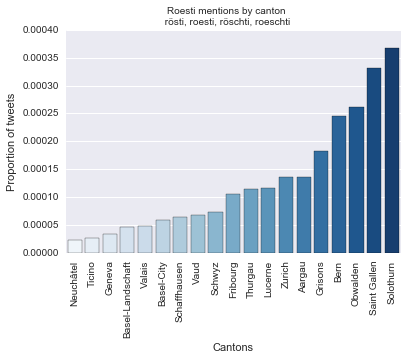

In [34]:
plot = sns.barplot(roesti_ratios.index, roesti_ratios.values, palette="Blues")
plot.set_xticklabels(roesti_ratios.index, rotation=90)
plot.set(xlabel='Cantons', ylabel='Proportion of tweets')
fig = plot.get_figure()
fig.suptitle('Roesti mentions by canton \n rösti, roesti, röschti, roeschti ')
fig.savefig("plots/roesti.png", bbox_inches='tight')

In [27]:
plot

## 2. CFF (keeping only relevant states)

In [10]:
def keep_relevant_states(df, threshold = 20):
    return df.groupby("geo_state").filter(lambda x: x.count()["main"] > threshold)

In [11]:
cff_search = search_df(main_df_opinion, ["cff", "sbb", "ffs"])
cff_search = keep_relevant_states(cff_search)
cff_scores = cff_search.groupby("geo_state")['sentiment'].mean().sort_values()

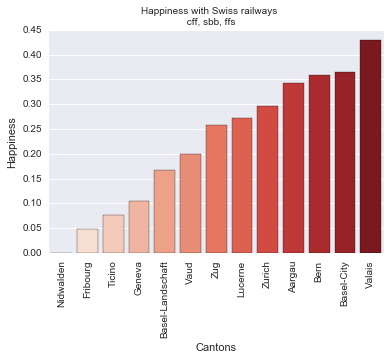

In [35]:
plot = sns.barplot(cff_scores.index, cff_scores.values, palette="Reds")
plot.set_xticklabels(cff_scores.index, rotation=90);
plot.set(xlabel='Cantons', ylabel='Happiness');
fig = plot.get_figure()
fig.suptitle('Happiness with Swiss railways \n cff, sbb, ffs ')
fig.savefig("plots/trains.png", bbox_inches='tight')

## 3. If the US presidency ran in Switzerland, who would win each state?

In [13]:
trump_search = search_df(main_df_opinion, ["donald", "trump"], search_exclusive=True)
trump_search = keep_relevant_states(trump_search, 5)

In [14]:
hillary_search = search_df(main_df_opinion, ["hillary", "clinton"], search_exclusive=True)
hillary_search = keep_relevant_states(hillary_search, 5)

In [15]:
trump_score = trump_search.groupby("geo_state")['sentiment'].mean().sort_values()
hillary_score = hillary_search.groupby("geo_state")['sentiment'].mean().sort_values()

In [16]:
trump_score.rename('Trump Score')
hillary_score.rename('Clinton Score')
us_df = pd.concat([trump_score, hillary_score], axis=1)
us_df.columns = ['Trump Score', 'Hillary Score']
us_df.head(2)

,Trump Score,Hillary Score
Aargau,0.500000,0.090909
Basel-City,0.342857,0.250000


In [17]:
#plot = sns.barplot(us_df.index, us_df['Trump Score'].values, us_df['Hillary Score'] palette="Reds")
#plot.set_xticklabels(cff_scores.index, rotation=90);

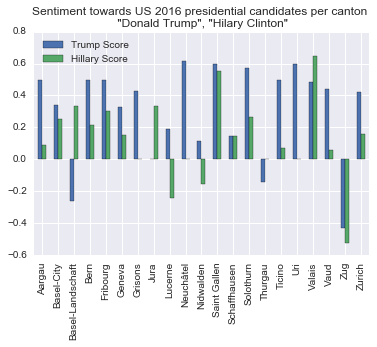

In [42]:
plot = us_df.plot(kind="bar")
plot.set_title('Sentiment towards US 2016 presidential candidates per canton \n "Donald Trump", "Hilary Clinton"')
fig = plot.get_figure()
fig.savefig('plots/us_presidency')

In [19]:
# sns.set(style="whitegrid")

# # Initialize the matplotlib figure
# f, ax = plt.subplots(figsize=(6, 15))

# # Load the example car crash dataset
# trump = us_df['Trump Score']
# clinton = us_df['Hillary Score']


# # Plot the total crashes
# sns.set_color_codes("pastel")
# sns.barplot(x=clinton, y=us_df.index,
#             label="Total", color="b")

# # Plot the crashes where alcohol was involved
# sns.set_color_codes("muted")
# sns.barplot(x=trump, y=us_df.index, 
#             label="Alcohol-involved", color="b")

# sns 

## 4. Where is the biggest Portugese community?

In [20]:
port_search = main_df[main_df['lang'] == 'pt'].groupby('geo_state').count().sort_values('main')['main']

In [21]:
port_tweets = port_search
total_tweets = main_df.groupby("geo_state")["main"].count()
port_ratios = (port_tweets / total_tweets).dropna().sort_values()

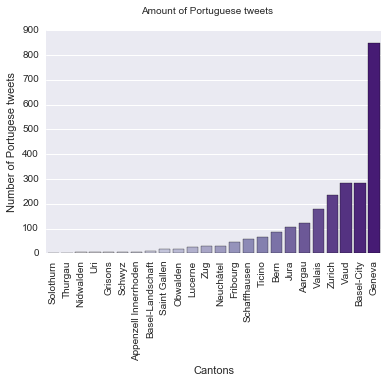

In [43]:
plot = sns.barplot(port_tweets.index, port_tweets.values, palette="Purples")
plot.set_xticklabels(port_tweets.index, rotation=90)
plot.set(xlabel='Cantons', ylabel='Number of Portugese tweets')
fig = plot.get_figure()
fig.suptitle('Amount of Portuguese tweets \n ')
fig.savefig("plots/portugese.png", bbox_inches='tight')

## 5 Does Switzerland like its president ?

do on website...

## 6 How does switzerland feel about lgbt community?  